# MRI Brain Tumor Classification

### Introduction

This is a personal project to practice image classification using tensorflow. The project should be run in WSL to utilize GPU acceleration to speed up training. 

The following __[dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data)__ is used for this project. The training and testing data is already separated by the creator of the dataset, so I will be using that split.


### Package Imports

In [70]:
import tensorflow as tf

import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#### Packages Used
* Tensorflow for neural network
* Pathlib for accessing dataset location
* Numpy for algebra operations
* Matplotlib for data visualization

### Image Preprocessing

In [6]:
data_dir = pathlib.Path('Dataset')
train_dir = (data_dir / 'Training')
test_dir = data_dir / 'Testing'

batch_size = 64
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=000,
    color_mode='grayscale',
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=000,
    color_mode='grayscale',
    image_size=(img_height, img_width),
    batch_size=batch_size)

num_classes = len(train_ds.class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


#### Input Data

Here is a bar graph of the number of training and testing data split by the the 4 possible classifications. And a table with the count of elements of each classification.

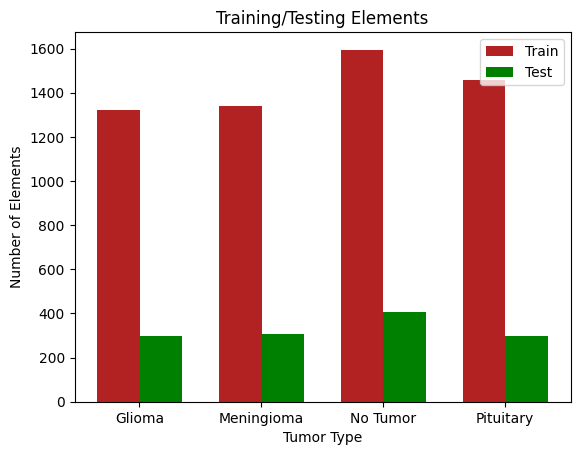

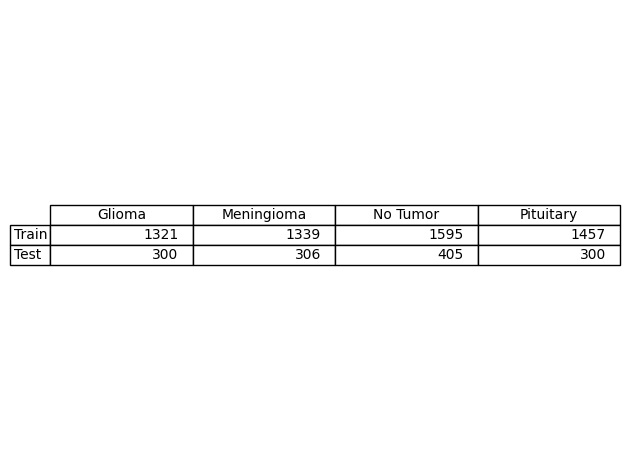

In [85]:
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

class_count_train = {'Glioma':0, 'Meningioma':0, 'No Tumor':0, 'Pituitary':0}
class_count_val = {'Glioma':0, 'Meningioma':0, 'No Tumor':0, 'Pituitary':0}
label_list = []

for images, labels in train_ds:
    for i in labels:
        class_count_train[class_names[i]] += 1
    

for images, labels in val_ds:
    label_list.extend(labels.numpy().tolist())
    for i in labels:
        class_count_val[class_names[i]] += 1

bar1 = np.arange(len(class_count_train)) 
bar2 = [x + 0.35 for x in bar1] 

plt.bar(bar1, list(class_count_train.values()), width=0.35, label='Train', color='firebrick')
plt.bar(bar2, list(class_count_val.values()), width=0.35, label='Test', color='green')
plt.xticks(np.arange(0.1725, 4.1725, 1), list(class_count_train.keys()))

plt.xlabel('Tumor Type')
plt.ylabel('Number of Elements')
plt.legend(['Train', 'Test'], loc='upper right')
plt.title('Training/Testing Elements')

plt.show()

labels = pd.Series(label_list)
val_count = labels.value_counts()

fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

df_dict = {'Glioma':[0,0], 'Meningioma':[0,0], 'No Tumor':[0,0], 'Pituitary':[0,0]}

for k in class_count_train.keys():
    df_dict[k] = [class_count_train[k], class_count_val[k]]

df = pd.DataFrame.from_dict(df_dict)

ax.table(cellText=df.values, colLabels=df.columns, loc='center', rowLabels=['Train', 'Test'])

fig.tight_layout()
plt.show()


Here are some example images from the verification dataset. They are grayscale, but are represented here with colors for higher contrast. The title above every image is its classification as provided by the dataset.

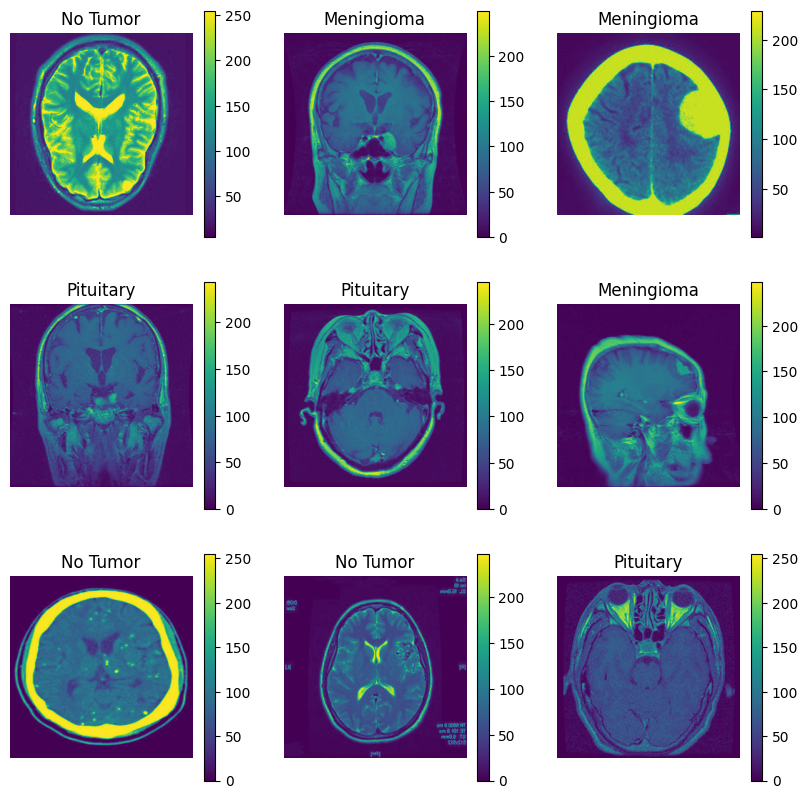

In [9]:

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
        plt.colorbar()

plt.show()

### Model Training

In [7]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15


90/90 [==============================] - 71s 780ms/step - loss: 0.6794 - accuracy: 0.7258 - val_loss: 0.6427 - val_accuracy: 0.7796
Epoch 2/15
90/90 [==============================] - 74s 825ms/step - loss: 0.3317 - accuracy: 0.8792 - val_loss: 0.5302 - val_accuracy: 0.8360
Epoch 3/15
90/90 [==============================] - 68s 762ms/step - loss: 0.2089 - accuracy: 0.9230 - val_loss: 0.5412 - val_accuracy: 0.8246
Epoch 4/15
90/90 [==============================] - 69s 765ms/step - loss: 0.1361 - accuracy: 0.9554 - val_loss: 0.1873 - val_accuracy: 0.9382
Epoch 5/15
90/90 [==============================] - 70s 781ms/step - loss: 0.0858 - accuracy: 0.9697 - val_loss: 0.1770 - val_accuracy: 0.9306
Epoch 6/15
90/90 [==============================] - 69s 766ms/step - loss: 0.0681 - accuracy: 0.9758 - val_loss: 0.2000 - val_accuracy: 0.9405
Epoch 7/15
90/90 [==============================] - 69s 773ms/step - loss: 0.0307 - accuracy: 0.9928 - val_loss: 0.1659 - val_accuracy: 0.9527
Epoch 8/15

This was run directly through windows and did not have the GPU speedup that WSL would provide. With the speedup a single epoch lasts around 11s on my machine, so around a 6x speed-up. 

The model ends with a 97% accuracy with around a 1% margin of error after 15 epochs.

### Results

##### Model Testing

In [49]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(val_ds)

21/21 [==============================] - 4s 162ms/step


Here is a display of some images from the validation set followed by a bar graph of the predictions made by the model. The classifications have been shortened to the first letter due to the large graphic. The model's prediction is written out above the image, it will be red if the model is incorrect. Likewise, only the correct bar in the bar graph will be blue, the incorrect predictions will be red.

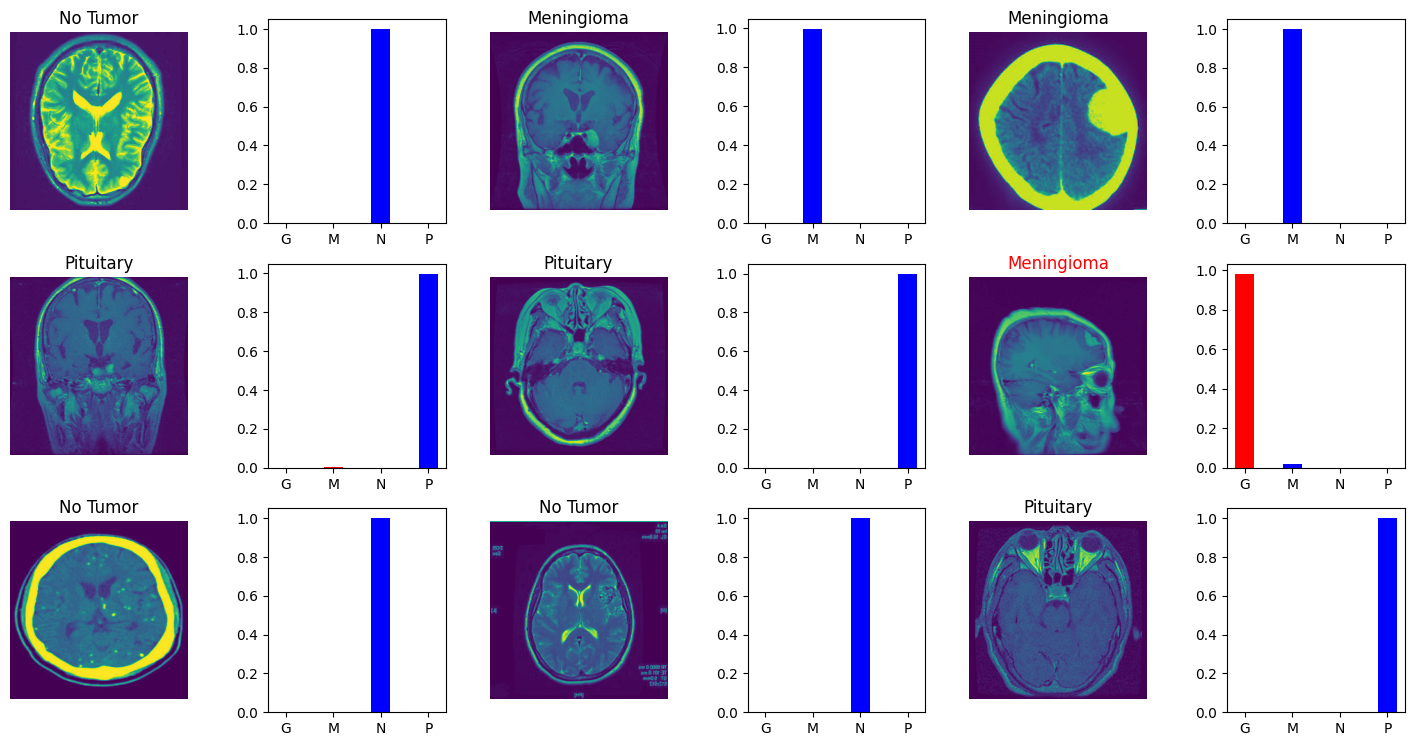

<Figure size 640x480 with 0 Axes>

In [62]:
class_names_short = ['G', 'M', 'N', 'P']
bar_colors = ['red', 'red', 'red', 'red']

fig = plt.figure(figsize=(18, 9))

outer = gridspec.GridSpec(3, 3, wspace=0.1, hspace=0.2)

for i in range(9):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[i], wspace=0.45, hspace=0.2)

    image = plt.Subplot(fig, inner[0])
    graph = plt.Subplot(fig, inner[1])

    # Image settings
    image.imshow(images[i].numpy())
    image.axis('off')
    image.title.set_text(class_names[label_list[i]])
    if(np.argmax(predictions[i]) != label_list[i]):
        image.title.set_color('red')

    # Graph settings
    bar_colors[label_list[i]] = 'blue'
    graph.bar(class_names_short, predictions[i], width=0.4, color = bar_colors)
    
    # Plotting Data    
    fig.add_subplot(image)
    fig.add_subplot(graph)

    # Resetting colors
    for i in range(len(bar_colors)):
            bar_colors[i] = 'red'
plt.show()
plt.set_cmap("viridis") 

##### Model Statistics

Here are two line graphs demonstrating model accuracy and model loss over the epochs. The higher training accuracy and lower loss value compared to testing data indicate slight overfitting

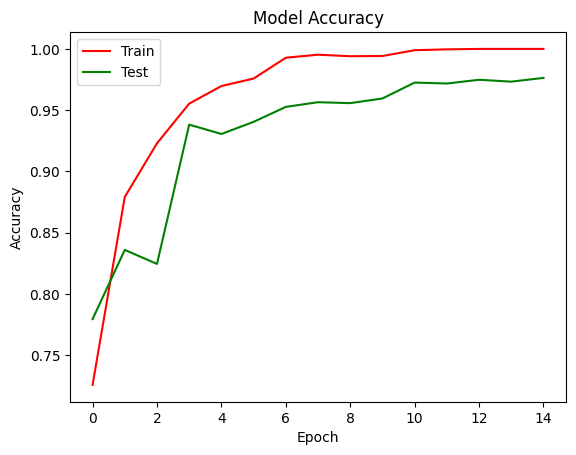

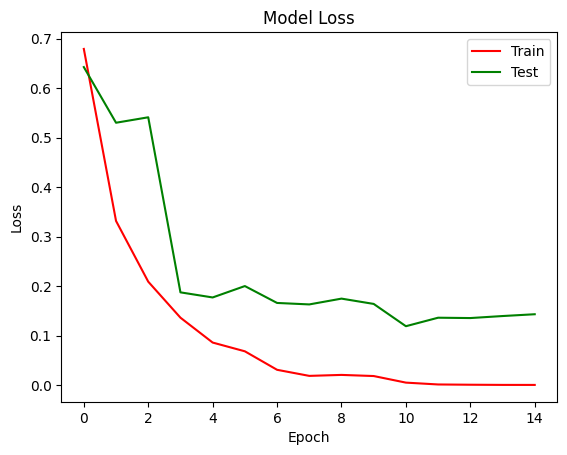

In [86]:
plt.plot(history.history['accuracy'], color='red')
plt.plot(history.history['val_accuracy'], color='green')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

##### Prediction Accuracy

Here is a heatmap of the incorrect predictions that the model has made. The model struggles with Meningiomas the most. 

The improper classifications come from(Most->Least common):
1. Glicomas being classified as Meningiomas
1. Meningiomas being misclassified as Giomas 
1. Meningiomas being misclassified as No Tumors 
1. Meningiomas being misclassified as Pituitary
1. Pituatary being misclassified as Meningiomas

This is still quite good accuracy since it has a (1 - 17/306)~94% chance of classifying a Meningioma properly.

This model does not have false positives in the tests run.

The model also has a (7/906)~0.772% chance to throw a false negative.

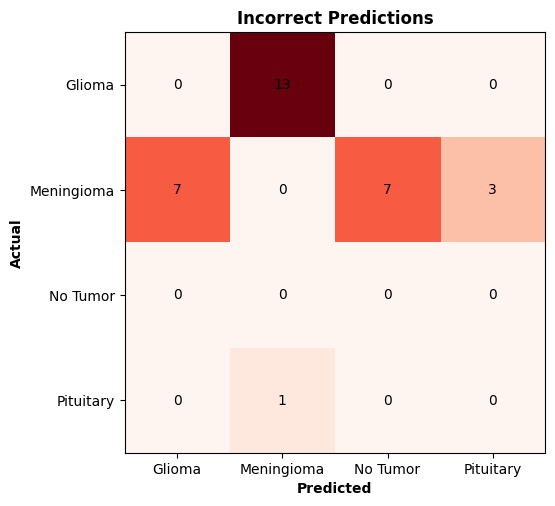

In [67]:
# Rows: Actual
# Columns: Predictions
wrong_predictions = [[0,0,0,0],
                     [0,0,0,0],
                     [0,0,0,0],
                     [0,0,0,0],]

# Counting incorrect predictions and classifying them
for i in range(len(label_list)):
    if (label_list[i] != np.argmax(predictions[i])):
        wrong_predictions[label_list[i]][np.argmax(predictions[i])] += 1

wrong_predictions = np.array(wrong_predictions)


# Heatmap settings
fig, ax = plt.subplots()
fig.tight_layout()
im = ax.imshow(wrong_predictions, cmap='Reds')
ax.set_xticks(range(4), labels=class_names)
ax.set_yticks(range(4), labels=class_names)
plt.ylabel('Actual', weight='bold')
plt.xlabel('Predicted', weight='bold')
plt.title('Incorrect Predictions', weight='bold')

for i in range(4):
    for j in range(4):
        text = ax.text(j, i, wrong_predictions[i, j],
                       ha="center", va="center")

count = 0
for i in label_list:
    if i == 1:
        count+=1
print(count)

We can have a look at the images that the model misclassifies.